<a href="https://colab.research.google.com/github/inclinedadarsh/dl-assignments/blob/main/dl-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization Techniques on MNIST with PyTorch

## Setup: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Load MNIST Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.44MB/s]


## Define Simple MLP Model

In [3]:
class MLP(nn.Module):
    def __init__(self, use_dropout=False):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5) if use_dropout else None
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout(x)
        x = self.relu(self.fc2(x))
        if self.dropout:
            x = self.dropout(x)
        x = self.fc3(x)
        return x

## Training Function

In [4]:
def train_model(model, optimizer, criterion, epochs=10, l2_lambda=0.0):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # L2 regularization
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        train_accs.append(100. * correct / len(train_loader.dataset))
        val_accs.append(100. * val_correct / len(test_loader.dataset))

        print(f'Epoch {epoch+1}: Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_accs[-1]:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

## 1. Train Without Regularization

In [5]:
torch.manual_seed(42)
model_no_reg = MLP(use_dropout=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_reg.parameters(), lr=0.001)

hist_no_reg = train_model(model_no_reg, optimizer, criterion, epochs=10, l2_lambda=0.0)

Epoch 1: Train Acc: 92.15%, Val Acc: 95.25%
Epoch 2: Train Acc: 96.63%, Val Acc: 96.79%
Epoch 3: Train Acc: 97.52%, Val Acc: 97.27%
Epoch 4: Train Acc: 97.98%, Val Acc: 96.89%
Epoch 5: Train Acc: 98.45%, Val Acc: 97.74%
Epoch 6: Train Acc: 98.66%, Val Acc: 97.26%
Epoch 7: Train Acc: 98.85%, Val Acc: 97.45%
Epoch 8: Train Acc: 99.04%, Val Acc: 97.70%
Epoch 9: Train Acc: 99.16%, Val Acc: 97.54%
Epoch 10: Train Acc: 99.27%, Val Acc: 97.61%


## 2. Train With L2 Regularization (weight_decay in optimizer)

In [6]:
torch.manual_seed(42)
model_l2 = MLP(use_dropout=False)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=1e-4)  # L2

hist_l2 = train_model(model_l2, optimizer_l2, criterion, epochs=10, l2_lambda=0.0)

Epoch 1: Train Acc: 92.16%, Val Acc: 95.41%
Epoch 2: Train Acc: 96.56%, Val Acc: 96.95%
Epoch 3: Train Acc: 97.45%, Val Acc: 97.31%
Epoch 4: Train Acc: 97.98%, Val Acc: 97.36%
Epoch 5: Train Acc: 98.27%, Val Acc: 97.58%
Epoch 6: Train Acc: 98.64%, Val Acc: 97.18%
Epoch 7: Train Acc: 98.68%, Val Acc: 97.17%
Epoch 8: Train Acc: 98.95%, Val Acc: 97.99%
Epoch 9: Train Acc: 98.98%, Val Acc: 97.78%
Epoch 10: Train Acc: 99.09%, Val Acc: 97.67%


## 3. Train With Dropout

In [7]:
torch.manual_seed(42)
model_dropout = MLP(use_dropout=True)
optimizer_drop = optim.Adam(model_dropout.parameters(), lr=0.001)

hist_drop = train_model(model_dropout, optimizer_drop, criterion, epochs=10, l2_lambda=0.0)

Epoch 1: Train Acc: 82.04%, Val Acc: 93.93%
Epoch 2: Train Acc: 90.17%, Val Acc: 95.22%
Epoch 3: Train Acc: 91.60%, Val Acc: 95.79%
Epoch 4: Train Acc: 92.20%, Val Acc: 95.94%
Epoch 5: Train Acc: 92.78%, Val Acc: 96.27%
Epoch 6: Train Acc: 93.13%, Val Acc: 96.33%
Epoch 7: Train Acc: 93.42%, Val Acc: 96.66%
Epoch 8: Train Acc: 93.59%, Val Acc: 96.84%
Epoch 9: Train Acc: 93.58%, Val Acc: 96.78%
Epoch 10: Train Acc: 93.92%, Val Acc: 96.66%


## Visualize Results

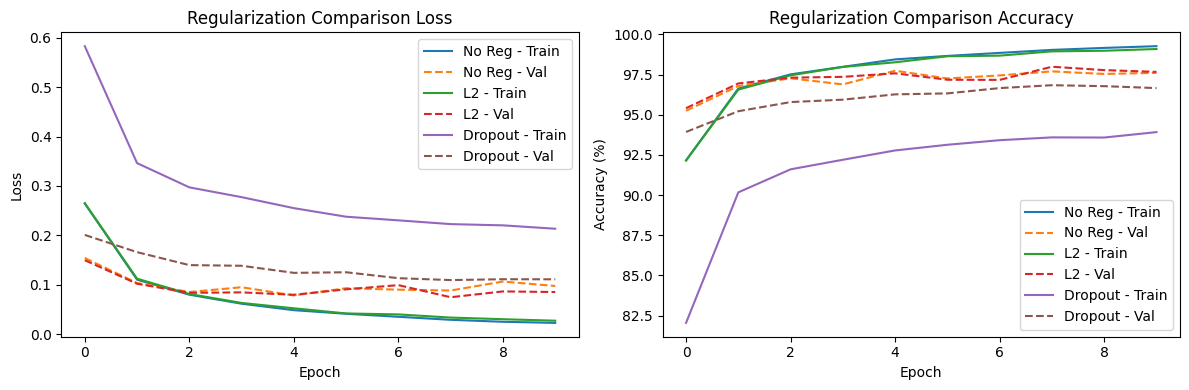

In [8]:
def plot_history(histories, labels, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for h, label in zip(histories, labels):
        plt.plot(h[0], label=f'{label} - Train')
        plt.plot(h[1], '--', label=f'{label} - Val')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for h, label in zip(histories, labels):
        plt.plot(h[2], label=f'{label} - Train')
        plt.plot(h[3], '--', label=f'{label} - Val')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history([hist_no_reg, hist_l2, hist_drop],
             ['No Reg', 'L2', 'Dropout'],
             'Regularization Comparison')

## Summary
- **No Regularization**: Highest training accuracy, risk of overfitting.
- **L2 Regularization**: Smoother generalization, slightly lower train acc.
- **Dropout**: Prevents overfitting, best validation performance.

> **Key Takeaway**: Dropout and L2 help reduce overfitting. Use validation curves to compare.